In [1]:
import json
import numpy as np
import csv
import scipy.stats.distributions
from scipy.spatial.transform import Rotation
import os
from matplotlib import pyplot as plt
import random
import math
import cvxpy as cp
import csv

# Helper Functions

### DIspersion filter

In [3]:
def dispersion_filtering(x, y, dispersion_threshold = 6, duraiton_threshold=0.2):
    start = 0
    window = []
    if len(x) == 0:
        return [], []
    fps = int(np.round(1/(x[1] - x[0])))
    duration_threshold_frames = np.ceil(duraiton_threshold * fps)
    
    def dispersion(arr):
        # input is a 2d array
        disp = np.max(arr[:, 0]) - np.min(arr[:, 0]) + np.max(arr[:, 1]) - np.min(arr[:, 1])
        return disp

    fixations = []
    fixations_intervals = []
    
    # while there are still points
    while int(start+duration_threshold_frames) < y.shape[0]:
        # initialize a window:
        window = list(range(int(start), int(start+duration_threshold_frames)))
        start = start + duration_threshold_frames
        disp = dispersion(y[window])
        # while the dispersion is less than the threshold
        while disp <= dispersion_threshold:
            if window[-1]+1 < y.shape[0]:
                window.append(window[-1]+1)
            start = start + 1
            if start >= y.shape[0]:
                break
            disp = dispersion(y[window])

        # if the current set of points never fit the duration criteria
        if len(window) <= duration_threshold_frames:
            start = start + 1
        # otherwise note it as fixations
        else:
            centroid = np.mean(y[window], axis=0)
            duration = (window[-1] - window[0]) / fps
            fixations.append([centroid[0], centroid[1], duration])
            fixations_intervals.append([window[0], window[-1]])
    fixations = np.array(fixations)
    return fixations, fixations_intervals


### Find Head Angle

In [4]:
def get_head_angles(head_dir, target_dir, target_fixations_intervals, target_fixation_duration, persistant_target_angle = 0):
    # find the head fixations that are within the target fixations
    head_fixation_final_val = []
    head_fixations_closest_val = []
    head_fixations_extreme_val = [] # not being used
    head_fixations_value_held = [] # not being used 
    head_fixations_value_held_isValid = [] # not being used
    # find a few head fixations that are within the target fixations
    non_zero_fixation_angles = []
    non_zero_fixation_duration = []
    # find a few head fixations that are within the target fixations
    for i in range(0, len(target_fixations_intervals)):
        angle = target_dir[target_fixations_intervals[i][0]:target_fixations_intervals[i][1], 2].mean()
        if np.abs(angle - persistant_target_angle) > 0:
            non_zero_fixation_angles.append(angle) # this only record non-zero angles
            non_zero_fixation_duration.append(target_fixation_duration[i])
            target_interval = target_fixations_intervals[i]
            start = target_interval[0]
            end = target_interval[1]
            ################# find the head intervals that starts within the target interval, and use average as angle of the head #################
            # intersected = []
            # for j in range(0, len(head_fixations_intervals)):
            #     if head_fixations_intervals[j][0] >= start and head_fixations_intervals[j][0] <= end:
            #         intersected.append(j)
            # # the fixation interval closest to the target interval is selected
            # closest_angle = 10000000
            # closest_index = -100
            # if len(intersected) > 0:
            #     for j in intersected:
            #         head_fixation_value = head_dir[head_fixations_intervals[j][0]:head_fixations_intervals[j][1]][:, 2].mean()
            #         target_angle = target_dir[target_fixations_intervals[i][0]:target_fixations_intervals[i][1]][:, 2].mean()
            #         if np.abs(head_fixation_value - target_angle) < closest_angle:
            #             closest_angle = np.abs(head_fixation_value - target_angle)
            #             closest_index = j
            #     head_fixations_value_held.append(head_dir[head_fixations_intervals[closest_index][0]:head_fixations_intervals[closest_index][1]][:, 2].mean())
            #     head_fixations_value_held_isValid.append(True)
            # else:
            #     head_fixations_value_held.append(head_dir[target_fixations_intervals[i][0]:target_fixations_intervals[i][1]][:, 2].mean())
            #     head_fixations_value_held_isValid.append(False)
            
            ################# find the closest value within the target interval #################
            extreme_value_index = np.argmin(np.abs(head_dir[start:end][:, 2] - angle))
            head_fixations_closest_val.append(head_dir[start:end][:, 2][extreme_value_index])
            # if head_fixations_closest_val[-1] / target_dir[start:end][:, 2].mean() < 0:
            #     print("wrong sign")
            #     continue

            ################# find the extreme value within the target interval #################
            extreme_value_index = np.argmax(np.abs(head_dir[start:end][:, 2]))
            head_fixations_extreme_val.append(head_dir[start:end][:, 2][extreme_value_index])

            ################# find the final value within target interval #################
            head_fixation_final_val.append(head_dir[end][2])
            # plt.plot(head_dir[start:end][:, 0], head_dir[start:end][:, 2], label="head")
            # plt.plot(target_dir[start:end][:, 0], target_dir[start:end][:, 2], label="target")
            # plt.plot(head_dir[start:end][:, 0], np.ones(head_dir[start:end][:, 0].shape) * head_fixations_extreme_val[-1], label="head fixation (from extreme value method)")
            # plt.plot(head_dir[start:end][:, 0], np.ones(head_dir[start:end][:, 0].shape) * head_fixations_value_held[-1], label="head fixation (from value held method)")
            # plt.plot(head_dir[start:end][:, 0], np.ones(head_dir[start:end][:, 0].shape) * head_fixations_closest_val[-1], label="head fixation (from closest value method)")
            # plt.plot(head_dir[start:end][:, 0], np.ones(head_dir[start:end][:, 0].shape) * head_fixation_final_val[-1], label="head fixation (from final value method)")
          
            # plt.legend()
            # plt.show()
        else:
            head_fixations_closest_val.append(persistant_target_angle)
            head_fixations_extreme_val.append(persistant_target_angle)
            head_fixations_value_held.append(persistant_target_angle)
            head_fixations_value_held_isValid.append(False)
            non_zero_fixation_angles.append(persistant_target_angle)
            non_zero_fixation_duration.append(persistant_target_angle)
    
    head_fixations_closest_val = np.array(head_fixations_closest_val)
    head_fixations_extreme_val = np.array(head_fixations_extreme_val)
    head_fixations_value_held = np.array(head_fixations_value_held)
    head_fixations_value_held_isValid = np.array(head_fixations_value_held_isValid)
    head_fixation_final_val = np.array(head_fixation_final_val)
    non_zero_fixation_angles = np.array(non_zero_fixation_angles)
    non_zero_fixation_duration = np.array(non_zero_fixation_duration)
    
    return head_fixations_closest_val, non_zero_fixation_angles, non_zero_fixation_duration

        



### find CHOR

In [5]:
class GaussianKernal:
    def __init__(self, loc, sigma, amplitude):
        self.sigma = sigma
        self.loc = loc
        self.amplitude = amplitude
        self.gaussina = scipy.stats.distributions.norm(loc, sigma)
    def cumulate(self, t_arr, x_arr):
        # t_arr is the time array
        # x_arr is the value array, in which we will cumulate a series of GaussianKernals
        x_arr += self.amplitude * self.gaussina.pdf(t_arr)
        return x_arr

def generate_smooth_distribution(fixation_angles):
    # generate a smooth distribution of the fixation ang
    kernal_list = []
    kernal_std = 3
    kernal_amplitude = 1
    for i in range(len(fixation_angles)):
        kernal_list.append(GaussianKernal(fixation_angles[i], kernal_std, kernal_amplitude))
    t_arr = np.linspace(-100, 100, 1000)
    x_arr = np.zeros(t_arr.shape)
    for kernal in kernal_list:
        x_arr = kernal.cumulate(t_arr, x_arr)
    x_arr = x_arr/np.sum(x_arr)
    return t_arr, x_arr, kernal_list
def generate_CHOR_distribution(head_angles, target_angles, target_angle_distribution):
    # find the closest angle in the target angle distribution for each head angle
    head_kernal_list = []
    for i in range(len(target_angles)):
        closest_target_angle_index = np.argmin(np.abs(target_angle_distribution[0] - target_angles[i]))
        # scaling the amplitude of each head angle by the corresponding target angle distribution
        head_kernal_list.append(GaussianKernal(head_angles[i], 3, 1 / target_angle_distribution[1][closest_target_angle_index]))
    t_arr = np.linspace(-100, 100, 1000)
    x_arr = np.zeros(t_arr.shape)
    for kernal in head_kernal_list:
        x_arr = kernal.cumulate(t_arr, x_arr)
    x_arr = x_arr/np.sum(x_arr)
    # find start and end range that contains 90% of the distribution
    cumulative_x_arr = np.cumsum(x_arr)
    start_index = np.argmin(np.abs(cumulative_x_arr - 0.05))
    end_index = np.argmin(np.abs(cumulative_x_arr - 0.95))
    start_angle = t_arr[start_index]
    end_angle = t_arr[end_index]

    return t_arr, x_arr, start_angle, end_angle

def get_CHOR(fixation_angles, head_fixation_angles, angle_to_ignore=0):
    is_not_zero = np.where(np.abs(fixation_angles-angle_to_ignore) <= 1E-3, False, True)
    # is_not_zero = np.ones(fixation_angles.shape, dtype=bool)
    # is_not_zero = True

    target_angle_distribution = generate_smooth_distribution(fixation_angles[is_not_zero])
    head_angle_distribution = generate_CHOR_distribution(head_fixation_angles[is_not_zero], fixation_angles[is_not_zero], target_angle_distribution)
    CHOR_start, CHOR_end = head_angle_distribution[2], head_angle_distribution[3]
    return CHOR_start, CHOR_end, target_angle_distribution, head_angle_distribution



# Analyze The data from Issam, Stephan (Pilot 1)

In [6]:
input_dirs = ["/Users/evanpan/Desktop/Experiment_related_files/recordings/TEST_REPEATED_DIFFERENT_DWELL_PILOT_Issam/collectedData", 
              "/Users/evanpan/Desktop/Experiment_related_files/recordings/TEST_REPEATED_DIFFERENT_DWELL_PILOT_STEPHAN/collectedData"]
# input_dirs = ["/Users/evanpan/Desktop/Experiment_related_files/recordings/TEST_DENSE_DISTRIBUTION_PILOT/collectedData"]
all_eye_data = []
all_head_data = []
all_target_data = []
all_target_input = []
for input_dir in input_dirs:
    dirs = os.listdir(input_dir)
    recording_file_names = ['repeated_pilot360']
    data_types = ["gaze_dir", "head_dir", "head_pos", "target_pos"]
    # get duration of each trial:
    total_length = 0

    for fileName in recording_file_names:
        data_type = "gaze_dir"
        fullPath = os.path.join(input_dir, data_type + "_" + fileName + ".csv")
        eye_data = np.genfromtxt(fullPath, delimiter=',', dtype=float)
        
        data_type = "head_dir"
        fullPath = os.path.join(input_dir, data_type + "_" + fileName + ".csv")
        head_data = np.genfromtxt(fullPath, delimiter=',', dtype=float)
        
        data_type = "target_pos"
        fullPath = os.path.join(input_dir, data_type + "_" + fileName + ".csv")
        target_data = np.genfromtxt(fullPath, delimiter=',', dtype=float)
        
        all_eye_data.append(eye_data)
        all_head_data.append(head_data)
        all_target_data.append(target_data)
        
        setupFileName = os.path.join(*[input_dir, fileName+".json"])
        target_input = json.load(open(setupFileName, "r"))
        all_target_input.append(target_input)

FileNotFoundError: /Users/evanpan/Desktop/Experiment_related_files/recordings/TEST_REPEATED_CONTINIOUS_DWELL_PILOT_YIMA_FUTURE_CONDITIONS/collectedData/gaze_dir_repeated_pilot360.csv not found.

In [54]:
def align_target_and_results(collected_gaze, collected_duration, target_gaze, target_duration):
    deletion_index = -1
    for i in range(0, len(target_duration)):
        if np.abs(collected_gaze[i] - target_gaze[i]) > 1E-3:
            deletion_index = i
            break

    if deletion_index < 0:
        return target_gaze, target_duration
    else:
        new_target_gaze = np.concatenate([target_gaze[0:deletion_index], target_gaze[deletion_index+1:]])
        new_target_duration = np.concatenate([target_duration[0:deletion_index], target_duration[deletion_index+1:]])
        return new_target_gaze, new_target_duration

/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_60743/598034294.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  rot_y = np.sign(vec[0]) * (90 - np.arctan(abs(vec[2])/abs(vec[0])) * 180 / np.pi)


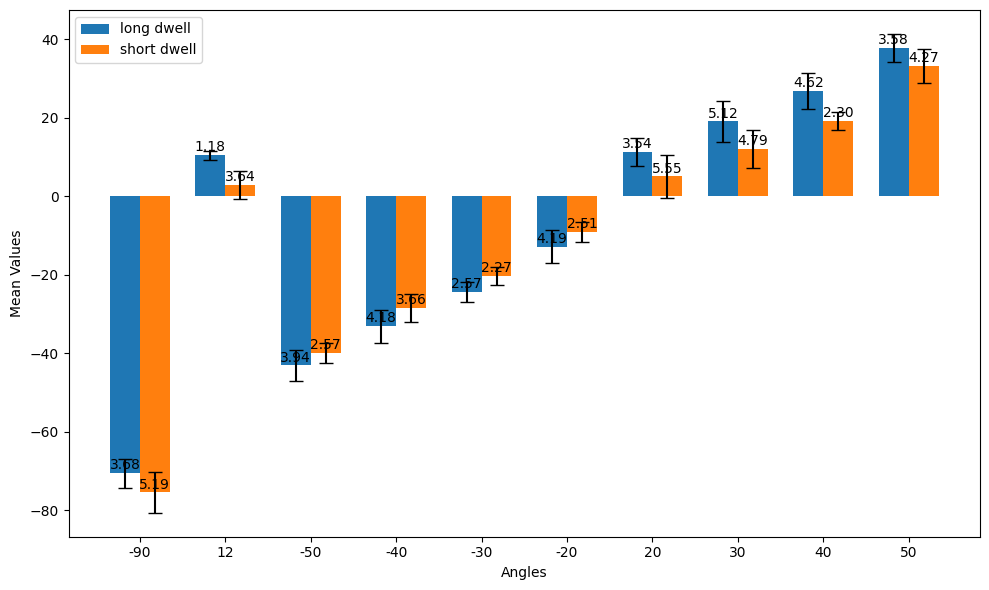

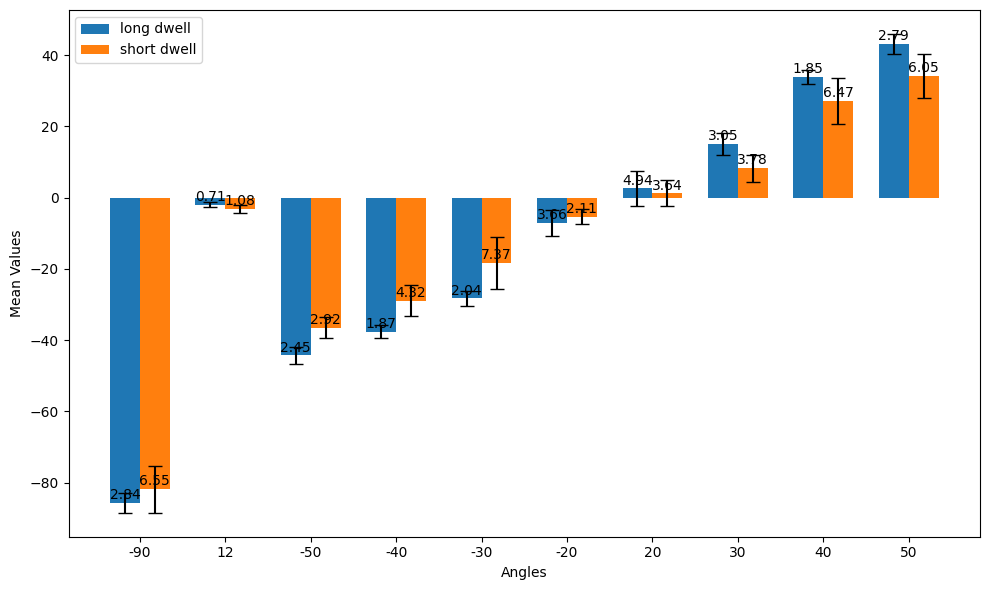

In [75]:
all_start_end_tuples = []
for cp in [0, 1]:
    start_end_tuples = []
    head_dir = all_head_data[cp]
    eye_dir = all_eye_data[cp]
    target_pos = all_target_data[cp]
    # prevent the angle from going to 360
    head_dir[:, 1:] = np.where(head_dir[:, 1:] > 180, head_dir[:, 1:] - 360, head_dir[:, 1:]) 
    eye_dir[:, 1:] = np.where(eye_dir[:, 1:] > 180, eye_dir[:, 1:] - 360, eye_dir[:, 1:])     
    
    neutral = np.array([0, 0, -1])
    target_dir = np.zeros(target_pos.shape)
    target_dir[:, 0] = target_pos[:, 0]
    for i in range(target_pos.shape[0]):
        # get the object rotation from scipy
        vec = target_pos[i, 1:]
        vec = vec / np.linalg.norm(vec)
        rot_y = np.sign(vec[0]) * (90 - np.arctan(abs(vec[2])/abs(vec[0])) * 180 / np.pi)
        # print(rot_y, target_dir[i, 2])
        target_dir[i, 2] = -rot_y

    # note the dispersion is originally for a 2D input array
    target_fixations, target_fixations_intervals = dispersion_filtering(target_dir[:, 0], target_dir[:, 1:], 0)
    target_fixations_angles = target_fixations[:, 1]
    target_fixation_duration = target_fixations[:, 2]

    # get the combined head and eye angles
    gaze_dir = eye_dir + head_dir
    gaze_fixations, gaze_fixations_intervals = dispersion_filtering(gaze_dir[:, 0], gaze_dir[:, 1:], 2)
    gaze_fixations_angles = gaze_fixations[:, 1]
    gaze_fixation_duration = gaze_fixations[:, 2]

    # get the target durations from the experimental setup file
    target_present_duration = all_target_input[cp]["duration"]
    valid_target_list = np.array(all_target_input[cp]["isTarget"])
    valid_target_list = np.where(valid_target_list==1, True, False)
    target_present_duration = np.array(target_present_duration)
    target_present_duration = target_present_duration[valid_target_list]
    target_fixation_angles = all_target_input[cp]["angle"]
    target_fixation_angles = np.array(target_fixation_angles)
    target_fixation_angles = target_fixation_angles[valid_target_list]

    head_fixation_angles, fixation_angles, fixation_duration = get_head_angles(head_dir, target_dir, target_fixations_intervals, target_fixation_duration, persistant_target_angle=0)
    
    # remove all the zero angles of collected data
    fixation_angles = np.array(fixation_angles)
    fixation_duration = np.array(fixation_duration)
    head_fixation_angles = np.array(head_fixation_angles)

    fixation_angles = fixation_angles[np.where(np.abs(fixation_angles) > 1E-3, True, False)]
    fixation_duration = fixation_duration[np.where(np.abs(fixation_duration) > 1E-3, True, False)]
    head_fixation_angles = head_fixation_angles[np.where(np.abs(head_fixation_angles) > 1E-3, True, False)]

    # remove all zero angles of the presented target angles
    target_present_duration = target_present_duration[np.where(np.abs(target_fixation_angles) >= 1E-3, True, False)]
    target_fixation_angles = target_fixation_angles[np.where(np.abs(target_fixation_angles) >= 1E-3, True, False)]
    target_fixation_angles, target_present_duration = align_target_and_results(fixation_angles, fixation_duration, target_fixation_angles, target_present_duration)
    # cluster the results into dictionaries
    result_dict_long_dwell = {}
    result_dict_short_dwell = {}
    for i in range(0, len(target_present_duration)):
        if target_present_duration[i] <= 0.2:
            try:
                result_dict_short_dwell[target_fixation_angles[i]].append(head_fixation_angles[i])
            except:
                result_dict_short_dwell[target_fixation_angles[i]] = [head_fixation_angles[i]]
        else:
            try:
                result_dict_long_dwell[target_fixation_angles[i]].append(head_fixation_angles[i])
            except:
                result_dict_long_dwell[target_fixation_angles[i]] = [head_fixation_angles[i]]
    angles = list(result_dict_long_dwell.keys())
    angles.sort()
    # plot the head angle for each pair of long/short dwell as side by side bar in a bar graph, with the angle as x axis, and the head angle as y axis, also shows the error bar
    long_dwell_angles = []
    long_dwell_angles_std = []
    short_dwell_angles = []
    short_dwell_angles_std = []
    for angle in angles:
        if angle != 20 or True:
            long_dwell_angles.append(np.mean(result_dict_long_dwell[angle]))
            long_dwell_angles_std.append(np.std(result_dict_long_dwell[angle]))
            short_dwell_angles.append(np.mean(result_dict_short_dwell[angle]))
            short_dwell_angles_std.append(np.std(result_dict_short_dwell[angle]))

    angles = [-90, 12, -50, -40, -30, -20, 20, 30, 40, 50]
    # Define the width of the bars
    bar_width = 0.35

    # Calculate the x-positions for the bars
    x_long = np.arange(len(angles))
    x_short = x_long + bar_width

    # Calculate means and standard deviations (replace with your actual data)
    long_dwell_angles = [np.mean(result_dict_long_dwell[angle]) for angle in angles]
    long_dwell_angles_std = [np.std(result_dict_long_dwell[angle]) for angle in angles]
    short_dwell_angles = [np.mean(result_dict_short_dwell[angle]) for angle in angles]
    short_dwell_angles_std = [np.std(result_dict_short_dwell[angle]) for angle in angles]

    # Plot the bar graph with error bars
    plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
    # plt.bar(x_long, long_dwell_angles, width=bar_width, label="long dwell", yerr=long_dwell_angles_std, capsize=5)
    # plt.bar(x_short, short_dwell_angles, width=bar_width, label="short dwell", yerr=short_dwell_angles_std, capsize=5)
    # Plot long dwell bars with error bars
    long_bars = plt.bar(x_long, long_dwell_angles, width=bar_width, label="long dwell", yerr=long_dwell_angles_std, capsize=5)

    # Plot short dwell bars with error bars
    short_bars = plt.bar(x_short, short_dwell_angles, width=bar_width, label="short dwell", yerr=short_dwell_angles_std, capsize=5)

    for bar, std_value in zip(long_bars + short_bars, long_dwell_angles_std + short_dwell_angles_std):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.2, f'{std_value:.2f}', ha='center', va='bottom')

    plt.xticks(x_long + bar_width / 2, angles)  # Set x-tick positions and labels
    plt.xlabel('Angles')
    plt.ylabel('Mean Values')
    plt.legend()
    plt.tight_layout()  # Ensure the labels fit within the figure
    plt.show()

    

# Analyze The data from Issam, Stephan (Pilot 2)

In [8]:
input_dirs = ["/Users/evanpan/Desktop/Experiment_related_files/recordings/TEST_REPEATED_CONTINIOUS_DWELL_PILOT_YIMA_FUTURE_CONDITIONS/collectedData",
              "/Users/evanpan/Desktop/Experiment_related_files/recordings/TEST_REPEATED_CONTINIOUS_DWELL_PILOT_DADA_FUTURE_CONDITIONS/collectedData",]
              # "/Users/evanpan/Desktop/Experiment_related_files/recordings/TEST_REPEATED_CONTINIOUS_DWELL_PILOT_MENGFEI_RANDOM_ORDER/collectedData",
              # "/Users/evanpan/Desktop/Experiment_related_files/recordings/TEST_REPEATED_CONTINIOUS_DWELL_PILOT_WARREN_RANDOM_ORDER/collectedData", 
              # "/Users/evanpan/Desktop/Experiment_related_files/recordings/TEST_REPEATED_CONTINIOUS_DWELL_PILOT_JOONHO_RANDOM_ORDER/collectedData",]

            #   "/Users/evanpan/Desktop/Experiment_related_files/recordings/TEST_REPEATED_CONTINIOUS_DWELL_PILOT_STEPHAN/collectedData", 
            #   "/Users/evanpan/Desktop/Experiment_related_files/recordings/TEST_REPEATED_CONTINIOUS_DWELL_PILOT_Issam/collectedData",
            #   "/Users/evanpan/Desktop/Experiment_related_files/recordings/TEST_REPEATED_CONTINIOUS_DWELL_PILOT_JM/collectedData",
            #   "/Users/evanpan/Desktop/Experiment_related_files/recordings/TEST_REPEATED_CONTINIOUS_DWELL_PILOT_RYAN/collectedData"
            #   ]
# input_dirs = ["/Users/evanpan/Desktop/Experiment_related_files/recordings/TEST_DENSE_DISTRIBUTION_PILOT/collectedData"]
all_eye_data = []
all_head_data = []
all_target_data = []
all_target_input = []
for input_dir in input_dirs:
    dirs = os.listdir(input_dir)
    recording_file_names = ['continiously_vary_dwell_pilot_random_order']
    data_types = ["gaze_dir", "head_dir", "head_pos", "target_pos"]
    # get duration of each trial:
    total_length = 0

    for fileName in recording_file_names:
        data_type = "gaze_dir"
        fullPath = os.path.join(input_dir, data_type + "_" + fileName + ".csv")
        eye_data = np.genfromtxt(fullPath, delimiter=',', dtype=float)
        
        data_type = "head_dir"
        fullPath = os.path.join(input_dir, data_type + "_" + fileName + ".csv")
        head_data = np.genfromtxt(fullPath, delimiter=',', dtype=float)
        
        data_type = "target_pos"
        fullPath = os.path.join(input_dir, data_type + "_" + fileName + ".csv")
        target_data = np.genfromtxt(fullPath, delimiter=',', dtype=float)
        
        all_eye_data.append(eye_data)
        all_head_data.append(head_data)
        all_target_data.append(target_data)
        
        setupFileName = os.path.join(*[input_dir, fileName+".json"])
        target_input = json.load(open(setupFileName, "r"))
        all_target_input.append(target_input)

In [9]:
def align_target_and_results(collected_gaze, collected_duration, target_gaze, target_duration):
    deletion_index = -1
    for i in range(0, len(target_duration)):
        if np.abs(collected_gaze[i] - target_gaze[i]) > 1E-3:
            deletion_index = i
            break

    if deletion_index < 0:
        return target_gaze, target_duration
    else:
        new_target_gaze = np.concatenate([target_gaze[0:deletion_index], target_gaze[deletion_index+1:]])
        new_target_duration = np.concatenate([target_duration[0:deletion_index], target_duration[deletion_index+1:]])
        return new_target_gaze, new_target_duration

/var/folders/dj/fb2zmgq93sv7xnbfzqj2n3pm0000gn/T/ipykernel_33784/3793847206.py:18: RuntimeWarning: divide by zero encountered in double_scalars
  rot_y = np.sign(vec[0]) * (90 - np.arctan(abs(vec[2])/abs(vec[0])) * 180 / np.pi)


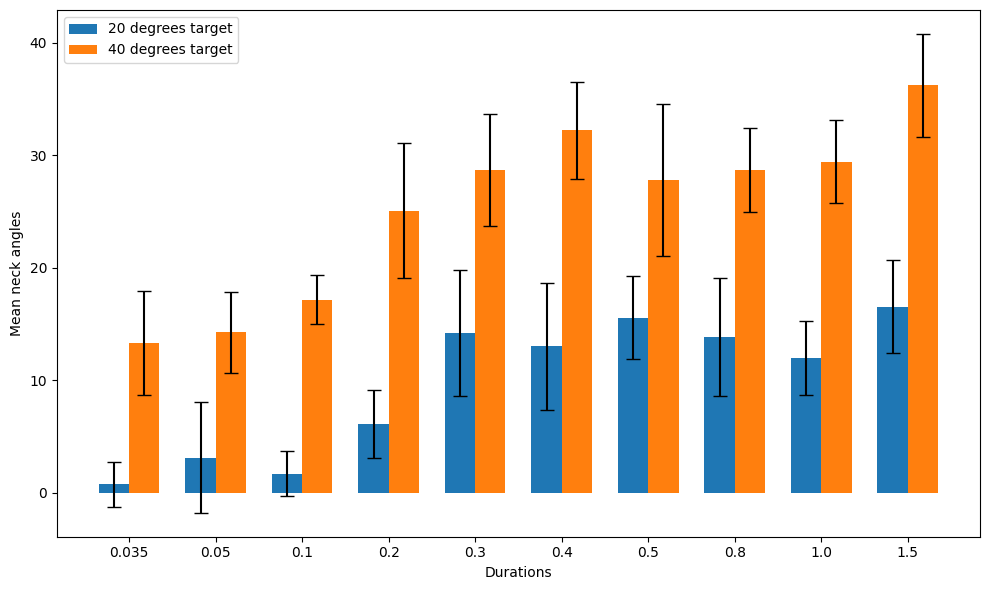

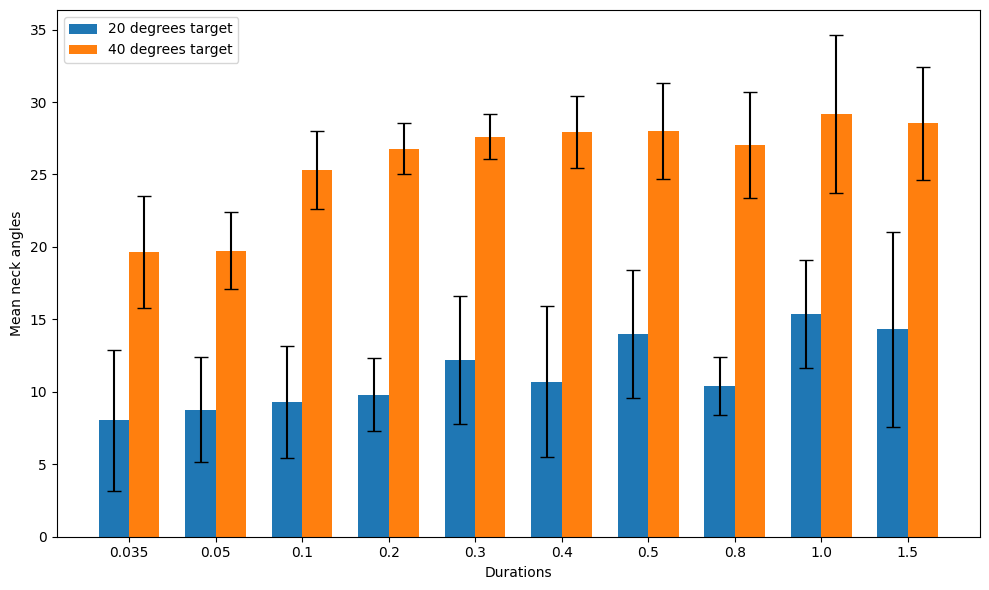

In [10]:
all_start_end_tuples = []
for cp in range(0, len(input_dirs)):
    start_end_tuples = []
    head_dir = all_head_data[cp]
    eye_dir = all_eye_data[cp]
    target_pos = all_target_data[cp]
    # prevent the angle from going to 360
    head_dir[:, 1:] = np.where(head_dir[:, 1:] > 180, head_dir[:, 1:] - 360, head_dir[:, 1:]) 
    eye_dir[:, 1:] = np.where(eye_dir[:, 1:] > 180, eye_dir[:, 1:] - 360, eye_dir[:, 1:])     
    
    neutral = np.array([0, 0, -1])
    target_dir = np.zeros(target_pos.shape)
    target_dir[:, 0] = target_pos[:, 0]
    for i in range(target_pos.shape[0]):
        # get the object rotation from scipy
        vec = target_pos[i, 1:]
        vec = vec / np.linalg.norm(vec)
        rot_y = np.sign(vec[0]) * (90 - np.arctan(abs(vec[2])/abs(vec[0])) * 180 / np.pi)
        # print(rot_y, target_dir[i, 2])
        target_dir[i, 2] = -rot_y

    # note the dispersion is originally for a 2D input array
    target_fixations, target_fixations_intervals = dispersion_filtering(target_dir[:, 0], target_dir[:, 1:], 0)
    target_fixations_angles = target_fixations[:, 1]
    target_fixation_duration = target_fixations[:, 2]

    # get the combined head and eye angles
    gaze_dir = eye_dir + head_dir
    gaze_fixations, gaze_fixations_intervals = dispersion_filtering(gaze_dir[:, 0], gaze_dir[:, 1:], 2)
    gaze_fixations_angles = gaze_fixations[:, 1]
    gaze_fixation_duration = gaze_fixations[:, 2]

    # get the target durations from the experimental setup file
    target_present_duration = all_target_input[cp]["duration"]
    valid_target_list = np.array(all_target_input[cp]["isTarget"])
    valid_target_list = np.where(valid_target_list==1, True, False)
    target_present_duration = np.array(target_present_duration)
    target_present_duration = target_present_duration[valid_target_list]
    target_fixation_angles = all_target_input[cp]["angle"]
    target_fixation_angles = np.array(target_fixation_angles)
    target_fixation_angles = target_fixation_angles[valid_target_list]

    head_fixation_angles, fixation_angles, fixation_duration = get_head_angles(head_dir, target_dir, target_fixations_intervals, target_fixation_duration, persistant_target_angle=0)
    
    # remove all the zero angles of collected data
    fixation_angles = np.array(fixation_angles)
    fixation_duration = np.array(fixation_duration)
    head_fixation_angles = np.array(head_fixation_angles)

    fixation_angles = fixation_angles[np.where(np.abs(fixation_angles) > 1E-3, True, False)]
    fixation_duration = fixation_duration[np.where(np.abs(fixation_duration) > 1E-3, True, False)]
    head_fixation_angles = head_fixation_angles[np.where(np.abs(head_fixation_angles) > 1E-3, True, False)]

    # remove all zero angles of the presented target angles
    target_present_duration = target_present_duration[np.where(np.abs(target_fixation_angles) >= 1E-3, True, False)]
    target_fixation_angles = target_fixation_angles[np.where(np.abs(target_fixation_angles) >= 1E-3, True, False)]
    target_fixation_angles, target_present_duration = align_target_and_results(fixation_angles, fixation_duration, target_fixation_angles, target_present_duration)

    # cluster the results into dictionaries by dwell time
    result_dict_angle_20 = {}
    result_dict_angle_40 = {}
    for i in range(0, fixation_angles.shape[0]):
        if np.abs(fixation_angles[i] - 20) <= 1E-3:
            try:
                result_dict_angle_20[target_present_duration[i]].append(head_fixation_angles[i])
            except:
                result_dict_angle_20[target_present_duration[i]] = [head_fixation_angles[i]]
        elif np.abs(fixation_angles[i] + 40) <= 1E-3:
            try:
                result_dict_angle_40[target_present_duration[i]].append(-head_fixation_angles[i])
            except:
                result_dict_angle_40[target_present_duration[i]] = [-head_fixation_angles[i]]
    
    # plot the result as bargraphs
    durations = list(result_dict_angle_20.keys())
    durations.sort()

    # Get the unique durations from both dictionaries
    durations = sorted(set(result_dict_angle_20.keys()) | set(result_dict_angle_40.keys()))

    # Calculate means for each duration from both dictionaries
    means_dict1 = [np.mean(result_dict_angle_20[duration]) if duration in result_dict_angle_20 else 0 for duration in durations]
    means_dict2 = [np.mean(result_dict_angle_40[duration]) if duration in result_dict_angle_40 else 0 for duration in durations]
    stds_dict1 = [np.std(result_dict_angle_20[duration]) if duration in result_dict_angle_20 else 0 for duration in durations]
    stds_dict2 = [np.std(result_dict_angle_40[duration]) if duration in result_dict_angle_40 else 0 for duration in durations]
    
    # Define the width of the bars
    bar_width = 0.35

    # Calculate the x-positions for the bars
    x_dict1 = np.arange(len(durations))
    x_dict2 = x_dict1 + bar_width


    plot_in_order = True
    # Plot the bar graphs
    if plot_in_order:
        plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

        # Plot bars for data_dict1
        bars_dict1 = plt.bar(x_dict1, means_dict1, width=bar_width, label="20 degrees target", yerr=stds_dict1, capsize=5)

        # Plot bars for data_dict2
        bars_dict2 = plt.bar(x_dict2, means_dict2, width=bar_width, label="40 degrees target", yerr=stds_dict2, capsize=5)

        plt.xticks(x_dict1 + bar_width / 2, durations)  # Set x-tick positions and labels
        plt.xlabel('Durations')
        plt.ylabel('Mean neck angles')
        plt.legend()
        plt.tight_layout()  # Ensure the labels fit within the figure
        plt.show()
    else:
         # Get the unique durations from both dictionaries
        durations_pairs = [[0.035, 0.5], [0.05, 0.8], [0.1, 1.0], [0.2, 1.5], [0.3, 0.4]]
        durations = []
        for i in durations_pairs:
            durations += i

        # Calculate means for each duration from both dictionaries
        means_dict1 = [np.mean(result_dict_angle_20[duration]) if duration in result_dict_angle_20 else 0 for duration in durations]
        means_dict2 = [np.mean(result_dict_angle_40[duration]) if duration in result_dict_angle_40 else 0 for duration in durations]
        stds_dict1 = [np.std(result_dict_angle_20[duration]) if duration in result_dict_angle_20 else 0 for duration in durations]
        stds_dict2 = [np.std(result_dict_angle_40[duration]) if duration in result_dict_angle_40 else 0 for duration in durations]
        
        # Define the width of the bars
        bar_width = 0.35

        # Calculate the x-positions for the bars
        x_dict1 = np.arange(len(durations))
        x_dict2 = x_dict1 + bar_width

        # Plot the bar graphs
        plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

        # Plot bars for data_dict1
        bars_dict1 = plt.bar(x_dict1, means_dict1, width=bar_width, label="20 degrees target", yerr=stds_dict1, capsize=5)

        # Plot bars for data_dict2
        bars_dict2 = plt.bar(x_dict2, means_dict2, width=bar_width, label="40 degrees target", yerr=stds_dict2, capsize=5)

        plt.xticks(x_dict1 + bar_width / 2, durations)  # Set x-tick positions and labels
        plt.xlabel('Durations')
        plt.ylabel('Mean neck angles')
        plt.legend()
        plt.tight_layout()  # Ensure the labels fit within the figure
        plt.show()

